In [305]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
import os
import numpy as np

## Part 1: Deceive the original model

In [91]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load the validation dataset
val_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [92]:
# Load the model params
model_dict = torch.load('./models/mnist_cnn.pt')

In [93]:
# Define the CNN model
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # First conv layer
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        # Second conv layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        # Max pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Flatten layer
        self.flatten = nn.Flatten()
        # Linear layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        # Dropout
        self.dropout = nn.Dropout(0.3)
        # ReLU
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x))) # Convolution 1 and pooling
        x = self.pool(self.relu(self.conv2(x))) # Convolution 2 and pooling
        x = self.flatten(x) # Flatten the output for the linear layers
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
# Load the model params
model_dict = torch.load('./models/mnist_cnn.pt')
model = Net()
model.load_state_dict(model_dict)

<All keys matched successfully>

In [94]:
# Evaluate the model on the validation dataset
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for data, target in val_loader:
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on validation data: {accuracy:.2f}%')

Accuracy on validation data: 99.24%


In [95]:
batch_size = 10
images = []
confidences = [0 for _ in range(10)]

# Create a batch of random images
train_images = torch.randn((batch_size, 1, 28, 28), requires_grad=True)
optimizer = optim.AdamW([train_images], lr=1e-2)
criterion = nn.CrossEntropyLoss()
targets = torch.arange(batch_size) # The target labels to train for

# Train the batch of images
num_epochs = 50
optimizer.zero_grad()
for epoch in range(num_epochs):
    outputs = model(train_images)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

# Evaluate the trained batch of images on the model
images.extend(train_images)

In [96]:
# Calculate the confidence of each image
for i in range(10):
    output = model(images[i].unsqueeze(0))
    confidences[i] = torch.softmax(output, dim=1)[0][i].item()
    

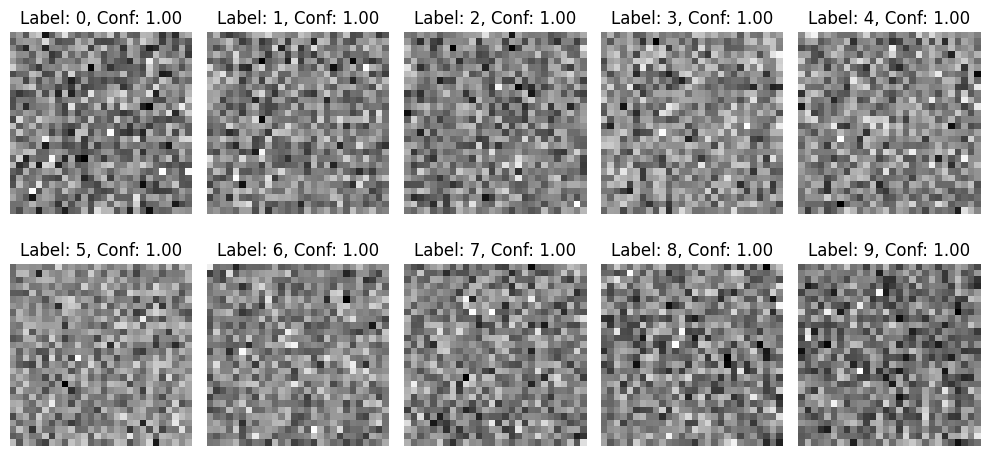

In [97]:
# Visualize all the images
fig, ax = plt.subplots(2, 5, figsize=(10, 5))
for i in range(2):
    for j in range(5):
        ax[i][j].imshow(images[i*5+j].detach().numpy().squeeze(), cmap='gray')
        ax[i][j].set_title(f'Label: {i*5+j}, Conf: {confidences[i*5+j]:.2f}')
        ax[i][j].axis('off')
plt.tight_layout()
plt.show()

# save the plot
fig.savefig('./images/mnist_confidence.png')


## Part 2: Guess using the improved network

In [112]:
class ImprovedNet(nn.Module):
    def __init__(self):
        super().__init__()
        # First conv layer
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        # Second conv layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        # Max pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Flatten layer
        self.flatten = nn.Flatten()
        # Linear layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 11) # 11 output classes, 10 means gibberish
        # Dropout
        self.dropout = nn.Dropout(0.3)
        # ReLU
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x))) # Convolution 1 and pooling
        x = self.pool(self.relu(self.conv2(x))) # Convolution 2 and pooling
        x = self.flatten(x) # Flatten the output for the linear layers
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
# Load the model params
model_dict = torch.load('./models/protect_mnist_cnn.pt')
model = ImprovedNet()
model.load_state_dict(model_dict)

<All keys matched successfully>

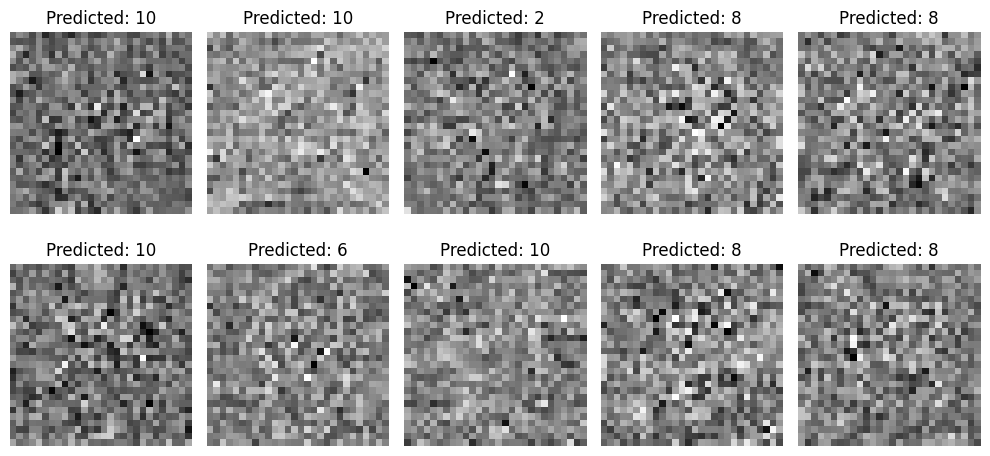

In [113]:
# Evaluate the improved model on the images
model.eval()
predictions = []

with torch.no_grad():
    for image in images:
        output = model(image.unsqueeze(0))
        _, predicted_label = torch.max(output.data, 1)
        predictions.append(predicted_label.item())

# Visualize the predictions
fig, ax = plt.subplots(2, 5, figsize=(10, 5))
for i in range(2):
    for j in range(5):
        ax[i][j].imshow(images[i*5+j].detach().numpy().squeeze(), cmap='gray')
        ax[i][j].set_title(f'Predicted: {predictions[i*5+j]}')
        ax[i][j].axis('off')
plt.tight_layout()
plt.show()

# Save the plot
fig.savefig('./images/improved_model_predictions.png')


There it is! The model predicts jibberish

## Part 3: Expose the new model
Now check what happens if we apply part 1 on the second model

In [126]:
batch_size = 11
confidences= [0 for _ in range(batch_size)]
images = []

# Create a batch of random images
train_images = torch.randn((batch_size, 1, 28, 28), requires_grad=True)
optimizer = optim.AdamW([train_images], lr=1e-2)
criterion = nn.CrossEntropyLoss()
targets = torch.arange(batch_size) # The target labels to train for

# Train the batch of images
num_epochs = 500
optimizer.zero_grad()
for epoch in range(num_epochs):
    outputs = model(train_images)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

# Evaluate the trained batch of images on the model
images.extend(train_images)

In [127]:
# Calculate the confidence of each image
for i in range(11):
    output = model(images[i].unsqueeze(0))
    confidences[i] = torch.softmax(output, dim=1)[0][i].item()

In [128]:
torch.softmax(output, dim=1)[0]

tensor([2.4550e-38, 0.0000e+00, 1.6816e-44, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.4725e-40, 0.0000e+00, 0.0000e+00, 1.1234e-41, 1.0000e+00],
       grad_fn=<SelectBackward0>)

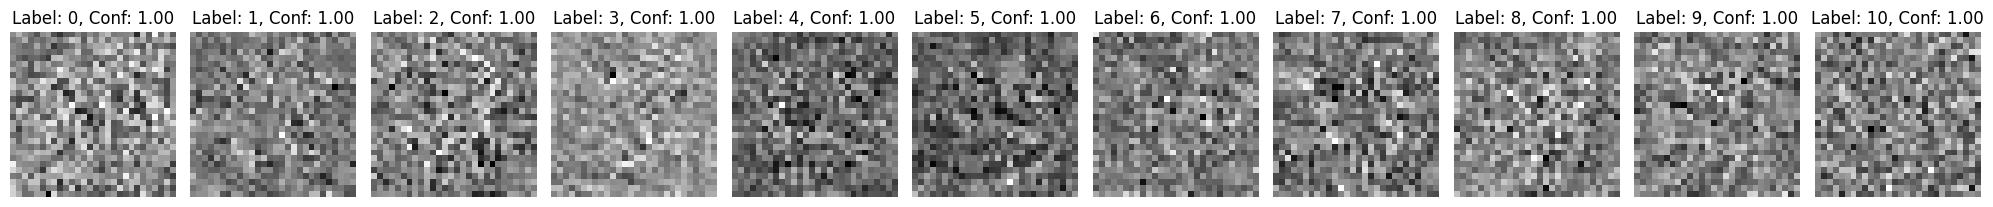

In [129]:
fig, ax = plt.subplots(1, 11, figsize=(20, 5))
for i in range(11):
    ax[i].imshow(images[i].detach().numpy().squeeze(), cmap='gray')
    ax[i].set_title(f'Label: {i}, Conf: {confidences[i]:.2f}')
    ax[i].axis('off')
plt.tight_layout()
plt.show()

# Save the plot
fig.savefig('./images/deceive_improved.png')


 Ah, the network failed us again, but we can see some strange patterns emerging now (5 seems like there is 5 hidden underneath?)

# Part 4: Rinse and repeat
Now what happens if we create a dataset of images like the above method, and feed it into the network with label 10?

In [259]:
# Create the extended dataset class
# This will be wonky, as we will just input the images and labels with transforms already in place
class ExtendedMNIST(MNIST):
    def __init__(self, *args, extra_data=None, **kwargs):
        super().__init__(*args, **kwargs)
        # extra_data should be a list of tuples (image, label)
        self.extra_data = extra_data or []

    def __len__(self):
        return super().__len__() + len(self.extra_data)

    def __getitem__(self, idx):
        if idx < super().__len__():
            return super().__getitem__(idx)
        else:
            # Adjust index for extra data
            idx -= super().__len__()
            image, label = self.extra_data[idx]
            return image, label
        
    def add_data(self, new_data):
        self.extra_data.extend(new_data)

In [138]:
# Create a new train dataset with mispredicted images
batch_size = 3000
confidences= [0 for _ in range(batch_size)]
mispredicted_images = []

# Create a batch of random images
train_images = torch.randn((batch_size, 1, 28, 28), requires_grad=True)
optimizer = optim.AdamW([train_images], lr=1e-2)
criterion = nn.CrossEntropyLoss()
targets = torch.randint(0, 11, (batch_size,))

# Train the batch of images
num_epochs = 200
optimizer.zero_grad()
for epoch in range(num_epochs):
    outputs = model(train_images)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    if epoch % 50 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item():.4f}')

mispredicted_images.extend(train_images)

Epoch: 0, Loss: 95.8722
Epoch: 50, Loss: 9.0679
Epoch: 100, Loss: 0.2100
Epoch: 150, Loss: 0.0078


In [145]:
file_path = './models/train_images.pt'
if not os.path.exists(file_path):
    torch.save(train_images, file_path)


In [146]:
test = torch.load(file_path)

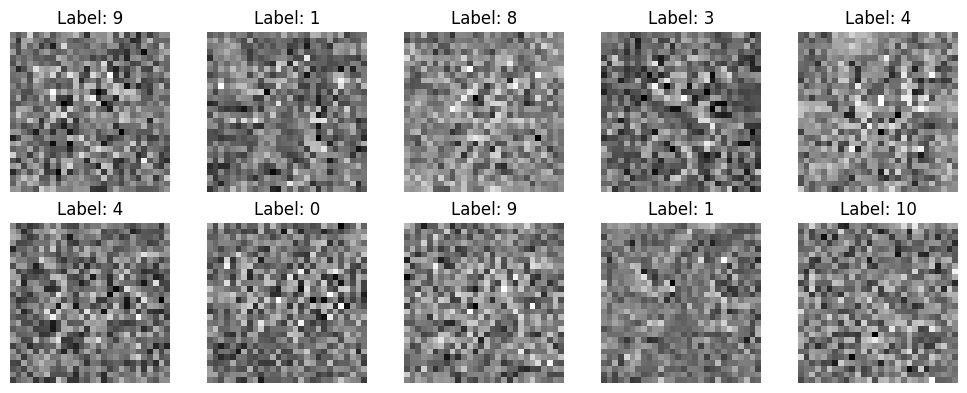

In [260]:
fig, ax = plt.subplots(2, 5, figsize=(10, 4))

for i in range(2):
    for j in range(5):
        index = i * 5 + j
        image = train_images[index].detach().numpy().squeeze()
        label = targets[index].item()
        
        ax[i][j].imshow(image, cmap='gray')
        ax[i][j].set_title(f'Label: {label}')
        ax[i][j].axis('off')

plt.tight_layout()
plt.show()

In [316]:
new_data = [(train_images[i], 10) for i in range(batch_size)]

# Create the new examples
train_count = 6000
val_count = 1000

# Create the additional examples as ndarrays
train_examples = [(transform((np.random.rand(28, 28).astype(np.float32))), 10) for _ in range(train_count)]
val_examples = [(transform((np.random.rand(28, 28).astype(np.float32))), 10) for _ in range(train_count)]

# Create the new dataset
extended_dataset = ExtendedMNIST('./data', train=True, download=True, transform=transform, extra_data=train_examples)
extended_dataset.add_data(new_data)
extended_train_loader = DataLoader(extended_dataset, batch_size=64, shuffle=True)

In [317]:
# Initialize the optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [318]:
# retrain the network
model.train()
num_epochs = 5
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(extended_train_loader):
        # Forward pass, backward pass, optimize
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        # Calculate metrics
        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
    # Print metrics for each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(extended_train_loader):.4f}, Accuracy: {(100*correct/total):.2f}%')

Epoch [1/5], Loss: 0.0253, Accuracy: 99.50%
Epoch [2/5], Loss: 0.0103, Accuracy: 99.64%
Epoch [3/5], Loss: 0.0097, Accuracy: 99.68%
Epoch [4/5], Loss: 0.0102, Accuracy: 99.69%
Epoch [5/5], Loss: 0.0101, Accuracy: 99.65%


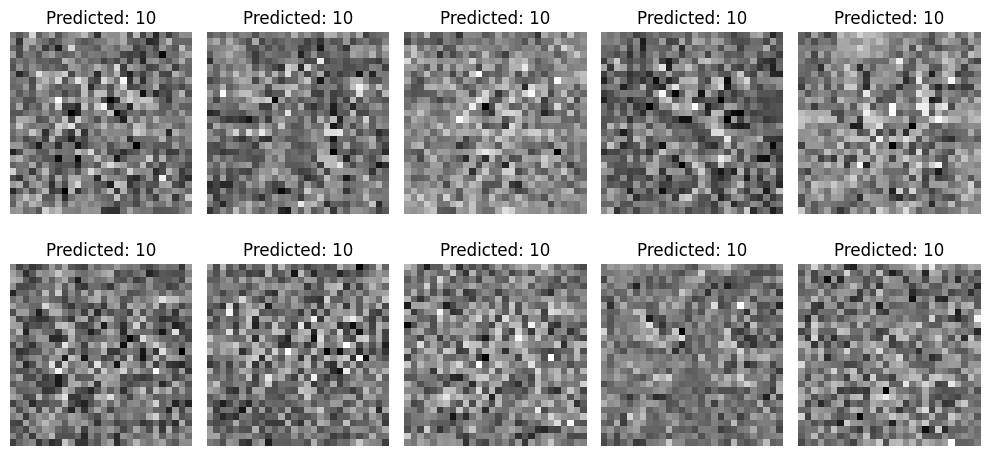

In [319]:
# Evaluate the improved model on the mispredicted images
model.eval()
predictions = []

with torch.no_grad():
    for image in images:
        output = model(image.unsqueeze(0))
        _, predicted_label = torch.max(output.data, 1)
        predictions.append(predicted_label.item())

# Visualize the predictions
fig, ax = plt.subplots(2, 5, figsize=(10, 5))
for i in range(2):
    for j in range(5):
        ax[i][j].imshow(images[i*5+j].detach().numpy().squeeze(), cmap='gray')
        ax[i][j].set_title(f'Predicted: {predictions[i*5+j]}')
        ax[i][j].axis('off')
plt.tight_layout()
plt.show()


In [323]:
# Create a new train dataset with mispredicted images
batch_size = 30
confidences= [0 for _ in range(batch_size)]
mispredicted_images = []

# Create a batch of random images
train_images = torch.randn((batch_size, 1, 28, 28), requires_grad=True)
optimizer = optim.AdamW([train_images], lr=1e-2)
criterion = nn.CrossEntropyLoss()
targets = torch.randint(0, 11, (batch_size,))

# Train the batch of images
num_epochs = 200
optimizer.zero_grad()
for epoch in range(num_epochs):
    outputs = model(train_images)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    if epoch % 50 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item():.4f}')
        
mispredicted_images.extend(train_images)

Epoch: 0, Loss: 162.5274
Epoch: 50, Loss: 52.2496
Epoch: 100, Loss: 4.0518
Epoch: 150, Loss: 0.2660


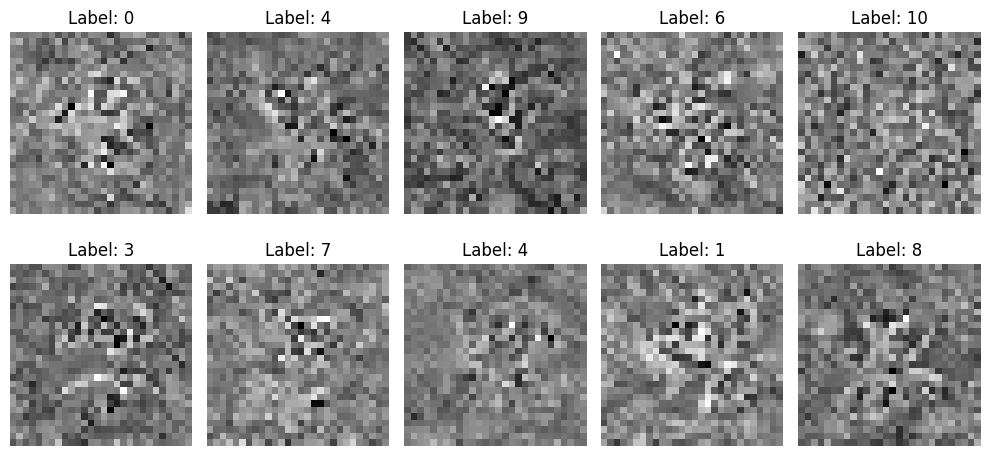

In [324]:
# Visualize the mispredicted images
fig, ax = plt.subplots(2, 5, figsize=(10, 5))
for i in range(2):
    for j in range(5):
        index = i * 5 + j
        image = mispredicted_images[index].detach().numpy().squeeze()
        label = targets[index].item()
        
        ax[i][j].imshow(image, cmap='gray')
        ax[i][j].set_title(f'Label: {label}')
        ax[i][j].axis('off')
        
plt.tight_layout()
plt.show()


As can be seen above, we can iterate, feed the trained images back into the network, but we can still manage to deceieve the network. A followup would be What happens if we could reiterate this many many times. Which is not ideal with my computer as each training around 10 minutes so iterating a meaningful amount of times would take many hours/days (2 trainings per iteration each around 10-15 minutes). I guess this could be improved by using a simpler model, but I don't we would get interesting looking patterns if we don't use a CNN.